In [1]:
import numpy as np
import cv2
import glob
import time
import pickle
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from utils import *

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
examples_car=glob.glob('vehicles/*/*.png')
examples_noncar=glob.glob('non-vehicles/*/*.png')

In [3]:
color_space='YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient=9 # HOG orientations
pix_per_cell=8 # HOG pixels per cell
cell_per_block=2 # HOG cells per block
hog_channel="ALL" # Can be 0, 1, 2, or "ALL"
spatial_size=(16,16) # Spatial binning dimensions
hist_bins=16 # Number of histogram bins

In [4]:
car_features=extract_features(examples_car,cspace=color_space,spatial_size=spatial_size,hist_bins=hist_bins,
                              orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                              hog_channel=hog_channel)
noncar_features=extract_features(examples_noncar,cspace=color_space,spatial_size=spatial_size,hist_bins=hist_bins,
                                 orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                 hog_channel=hog_channel)

In [5]:
X=np.vstack((car_features,noncar_features)).astype(np.float64)                        
X_scaler=StandardScaler().fit(X)
scaled_X=X_scaler.transform(X)

y=np.hstack((np.ones(len(car_features)),np.zeros(len(noncar_features))))

X_train,X_test,y_train,y_test=train_test_split(scaled_X,y,test_size=0.2,random_state=123)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and',cell_per_block,'cells per block')
print('Feature vector length:',len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [6]:
svc=LinearSVC()
t=time.time()
svc.fit(X_train,y_train)
t2=time.time()
training_time=round(t2-t,4)
print(training_time,'Seconds to train SVC...')

score=round(svc.score(X_test,y_test),4)
print('Test Accuracy =',score)

5.6803 Seconds to train SVC...
Test Accuracy = 0.9913


In [7]:
data={}
data['color_space']=color_space
data['svc']=svc
data['X_scaler']=X_scaler
data['orient']=orient
data['pix_per_cell']=pix_per_cell
data['cell_per_block']=cell_per_block
data['spatial_size']=spatial_size
data['hist_bins']=hist_bins
data['hog_channel']=hog_channel
with open('params.pickle','wb') as handle:
    pickle.dump(data,handle,protocol=pickle.HIGHEST_PROTOCOL)
    
with open('X_train.pickle','wb') as handle:
    pickle.dump(X_train,handle,protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle','wb') as handle:
    pickle.dump(y_train,handle,protocol=pickle.HIGHEST_PROTOCOL)
with open('X_test.pickle','wb') as handle:
    pickle.dump(X_test,handle,protocol=pickle.HIGHEST_PROTOCOL)
with open('y_test.pickle','wb') as handle:
    pickle.dump(y_test,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
try:
    svc
except NameError:
    with open('params.pickle','rb') as handle:
        params=pickle.load(handle)
    
    color_space=params['color_space']
    svc=params['svc']
    X_scaler=params['X_scaler']
    orient=params['orient']
    pix_per_cell=params['pix_per_cell']
    cell_per_block=params['cell_per_block']
    spatial_size=params['spatial_size']
    hist_bins=params['hist_bins']
    hog_channel=params['hog_channel']

In [3]:
test_imgs_path='./test_images/'
img_files=os.listdir(test_imgs_path)

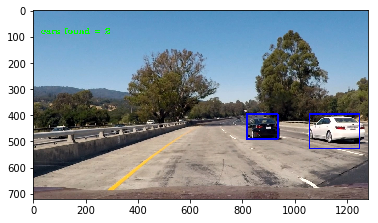

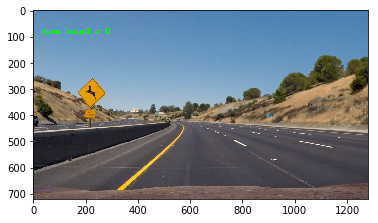

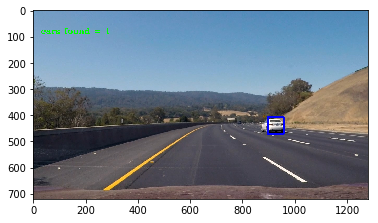

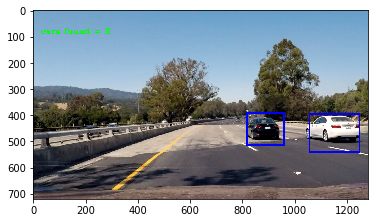

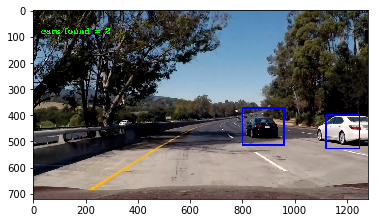

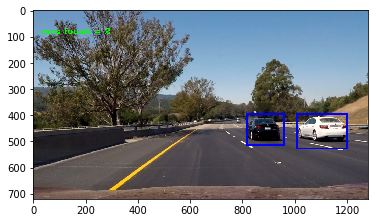

In [5]:
xy_window = [(64,64),(96,96),(128,128)]
y_start_stop = [[200,500],[300,600],[400,700]]

for img_file in img_files:
    if img_file.endswith('.jpg'):
        test_img_file=test_imgs_path+img_file
        test_img=mpimg.imread(test_img_file) # image read as jpg file - hange range from (0,255) to (0,1)
        test_img_=test_img.astype(np.float32)/255
        hist_bboxes=[]
        windows_list = []
        for i in range(len(xy_window)):
            windows=slide_window_find_cars(test_img_,svc,X_scaler,x_start_stop=[None,None],y_start_stop=y_start_stop[i],
                                           xy_window=xy_window[i],xy_overlap=(0.75,0.75),cspace=color_space,
                                           spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                           pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel="ALL")
            windows_list.append(windows) 
        windows_list = sum(windows_list,[])
        
        result,_=draw_boxes_thresholded(test_img,windows_list,hist_bboxes,hist_thresh=20,threshold=2)
        plt.figure()
        plt.imshow(result)
        plt.imsave('./output_images/'+img_file[:-4]+'_sliding_window.jpg',result)

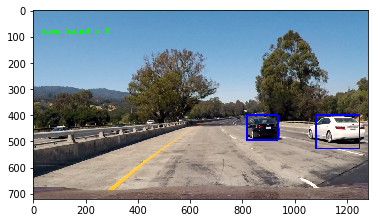

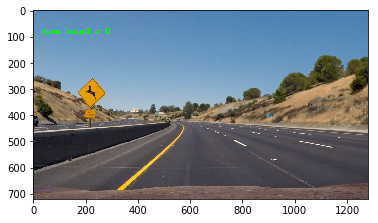

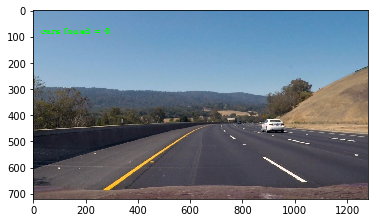

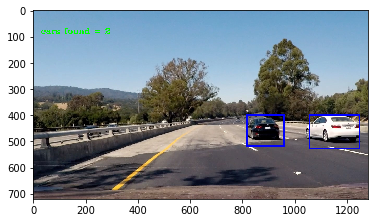

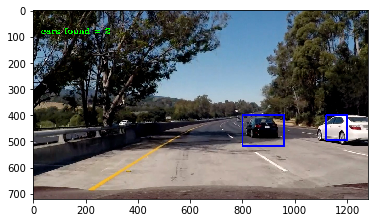

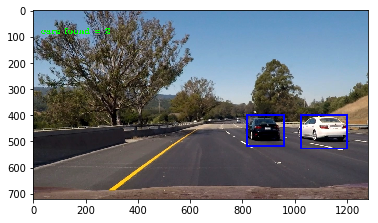

In [6]:
for img_file in img_files:
    if img_file.endswith('.jpg'):
        test_img_file=test_imgs_path+img_file
        test_img=mpimg.imread(test_img_file)
        windows_list=[]
        hist_bboxes=[]
        for scale in [1.5,2]:
            windows=find_cars(test_img,cspace=color_space,scale=scale,ystart=400,ystop=700,svc=svc,X_scaler=X_scaler,
                              orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                              spatial_size=spatial_size,hist_bins=hist_bins)
            windows_list.append(windows)
        windows_list=sum(windows_list,[])
        
        result,_=draw_boxes_thresholded(test_img,windows_list,hist_bboxes,hist_thresh=20,threshold=2)
        plt.figure()
        plt.imshow(result)
        plt.imsave('./output_images/'+img_file,result)

In [18]:
if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")

xy_window = [(96,96),(128,128)]
y_start_stop = [[300,600],[400,700]]

def process_frames(img):
    global hist_bboxes
    img_=img.astype(np.float32)/255
    windows_list=[]
    for i in range(len(xy_window)):
        windows=slide_window_find_cars(img_,svc,X_scaler,x_start_stop=[None,None],y_start_stop=y_start_stop[i],
                                       xy_window=xy_window[i],xy_overlap=(0.75,0.75),cspace=color_space,
                                       spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                       pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel="ALL")
        windows_list.append(windows) 
    windows_list = sum(windows_list,[])
    result,hist_bboxes=draw_boxes_thresholded(img,windows_list,hist_bboxes,hist_thresh=20,threshold=2)
    return result

def process_frames2(img):
    global hist_bboxes
    windows_list=[]
    for scale in [1.5,2]:
        windows=find_cars(img,cspace=color_space,scale=scale,ystart=400,ystop=700,svc=svc,X_scaler=X_scaler,
                          orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                          spatial_size=spatial_size,hist_bins=hist_bins)
        windows_list.append(windows) 
    windows_list = sum(windows_list,[])
    result,hist_bboxes=draw_boxes_thresholded(img,windows_list,hist_bboxes,hist_thresh=20,threshold=8)
    return result

In [19]:
white_output='test_videos_output/project_video.mp4'
clip1=VideoFileClip("./project_video.mp4")

hist_bboxes=[]
white_clip=clip1.fl_image(process_frames2)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:46<00:00,  1.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 13min 48s
